### predict the chances for a goal in the next minute

In [1]:
cd ..

/Users/nellekesmits/Documents/projects/notebook.goalpredictor


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsbombpy import sb
import notebooks.utils as utils
import SoccermaticsForPython.FCPython as sfp_fcp
import SoccermaticsForPython as sfp
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

#### get data - statsbomb

In [3]:
# check competitions 
competitions = sb.competitions()
competitions.loc[competitions['competition_name'] == 'UEFA Euro']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
38,55,43,Europe,UEFA Euro,male,False,True,2020,2022-02-01T17:20:34.319496,2021-11-11T13:54:37.507376,2021-11-11T13:54:37.507376,2022-02-01T17:20:34.319496


In [4]:
# select the UEFA euro's from 2020; could be nice to explore what's going on there
matches = sb.matches(competition_id=55, season_id=43)
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3788753,2021-06-16,15:00:00.000,Europe - UEFA Euro,2020,Finland,Russia,0,1,available,available,2021-11-11T14:00:16.105809,2021-09-22T16:39:05.697512,2,Group Stage,Saint-Petersburg Stadium,Danny Desmond Makkelie,Markku Kanerva,Stanislav Cherchesov,1.1.0,2,2
1,3788765,2021-06-20,18:00:00.000,Europe - UEFA Euro,2020,Switzerland,Turkey,3,1,available,available,2021-08-02T14:58:49.057,2021-11-11T13:54:37.507376,3,Group Stage,Bakı Olimpiya Stadionu,Slavko Vinčić,Vladimir Petković,Şenol Güneş,1.1.0,2,2
2,3795107,2021-07-02,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Italy,1,2,available,available,2022-02-01T17:20:34.319496,2021-09-23T00:02:51.495862,5,Quarter-finals,Allianz Arena,Slavko Vinčić,Roberto Martínez Montoliú,Roberto Mancini,1.1.0,2,2
3,3795221,2021-07-07,21:00:00.000,Europe - UEFA Euro,2020,England,Denmark,2,1,available,available,2021-07-09T12:38:23.437,2021-09-22T22:33:37.494366,6,Semi-finals,Wembley Stadium,Danny Desmond Makkelie,Gareth Southgate,Kasper Hjulmand,1.1.0,2,2
4,3795506,2021-07-11,21:00:00.000,Europe - UEFA Euro,2020,Italy,England,1,1,available,available,2021-07-12T12:27:50.647,2021-09-22T22:40:31.690550,7,Final,Wembley Stadium,Björn Kuipers,Roberto Mancini,Gareth Southgate,1.1.0,2,2


In [5]:
matches['score'] = matches['home_score'] + matches['away_score']
print('Aantal games:', len(matches['score']),
      'en aantal goals per game', round(np.mean(matches['score']), 2))

Aantal games: 51 en aantal goals per game 2.78


In [6]:
# matches['competition_stage'].value_counts()

In [7]:
# select all the events from all the worldcup matches
match_ids = matches['match_id'].unique()
total_events = []

for uniek_id in match_ids:
    events =sb.events(match_id=uniek_id)
    total_events.append(events)

In [8]:
# create one dataframe from all events of the games selected, and create a unique identifier per game + team.
events_all_matches = pd.concat(total_events)
events_all_matches['uniekid'] = (events_all_matches['match_id'] * 1000) + events_all_matches['possession_team_id']

In [9]:
print('Aantal games die zijn gespeeld: ', events_all_matches['match_id'].nunique())
print('Aantal uniekids die er zijn (2 per game): ', events_all_matches['uniekid'].nunique())
print('gemiddeld aantal shot_types per match: ', round(np.mean(events_all_matches.groupby('match_id')['shot_type'].count()),2))

Aantal games die zijn gespeeld:  51
Aantal uniekids die er zijn (2 per game):  102
gemiddeld aantal shot_types per match:  25.27


In [10]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,bad_behaviour_card,injury_stoppage_in_chain,pass_deflected,pass_inswinging,shot_one_on_one,block_deflection,block_save_block,foul_committed_penalty,foul_won_penalty,shot_deflected,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,player_off_permanent,shot_saved_off_target,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,dribble_no_touch,block_offensive,ball_recovery_offensive,shot_follows_dribble,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9427b18a-6b10-411f-90da-3d6240b80c71,1,NaN,NaN,3788753,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Finland,1835,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Finland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788754835


In [11]:
print('gemiddelde aantal regels per unieke game en team combinatie: ', np.mean(events_all_matches.groupby('uniekid').size()))
print('max aantal regels per unieke game en team combinatie: ', np.max(events_all_matches.groupby('uniekid').size()))
print('min aantal regels per unieke game en team combinatie: ', np.min(events_all_matches.groupby('uniekid').size()))

gemiddelde aantal regels per unieke game en team combinatie:  1889.1666666666667
max aantal regels per unieke game en team combinatie:  3599
min aantal regels per unieke game en team combinatie:  543


In [12]:
check_id = 3788750790
events_all_matches.loc[events_all_matches['uniekid'] == check_id].head(1)
# events_all_matches.loc[events_all_matches['uniekid'] == check_id, 'type'].value_counts()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,bad_behaviour_card,injury_stoppage_in_chain,pass_deflected,pass_inswinging,shot_one_on_one,block_deflection,block_save_block,foul_committed_penalty,foul_won_penalty,shot_deflected,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,player_off_permanent,shot_saved_off_target,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,dribble_no_touch,block_offensive,ball_recovery_offensive,shot_follows_dribble,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,uniekid
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.91143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e32b85c7-ab46-4c7c-b71f-e07113df8504,5,NaN,"[61.0, 40.1]",3788750,0,NaN,NaN,NaN,NaN,2.948046,NaN,Right Foot,NaN,NaN,"[36.0, 45.0]",NaN,Ground Pass,25.475676,NaN,NaN,NaN,NaN,Victor Nilsson Lindelöf,NaN,NaN,NaN,NaN,NaN,Kick Off,1,From Kick Off,Emil Peter Forsberg,5625.0,Left Midfield,2,Sweden,790,[658cf1c7-2306-4f52-b194-abd3b93042b7],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sweden,00:00:00.594,Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788750790


#### data exploration

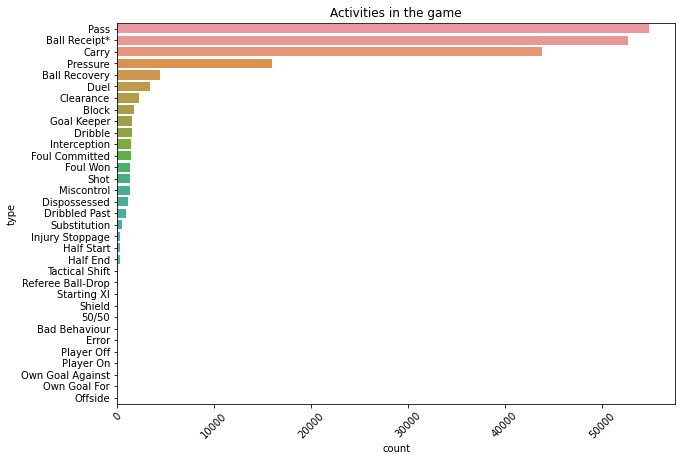

In [13]:
# which activities happen in the game?
fix, ax = plt.subplots(figsize=(10,7))
sns.countplot(y='type', 
              data=events_all_matches,
              order = events_all_matches['type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Activities in the game')
plt.show()

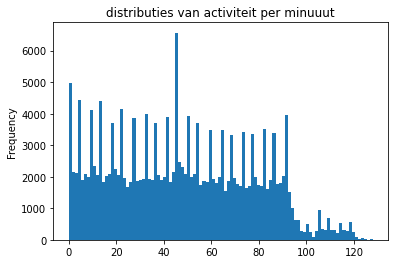

In [14]:
events_all_matches['minute'].plot(kind='hist', bins=100)
plt.title('distributies van activiteit per minuuut')
plt.show()

In [15]:
# sns.histplot(data=events_all_matches, x="minute",bins=30)

#### yvar opstellen

In [16]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,bad_behaviour_card,injury_stoppage_in_chain,pass_deflected,pass_inswinging,shot_one_on_one,block_deflection,block_save_block,foul_committed_penalty,foul_won_penalty,shot_deflected,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,player_off_permanent,shot_saved_off_target,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,dribble_no_touch,block_offensive,ball_recovery_offensive,shot_follows_dribble,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9427b18a-6b10-411f-90da-3d6240b80c71,1,NaN,NaN,3788753,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Finland,1835,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Finland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788754835


In [17]:
column_selection = ['uniekid', 'match_id', 'peil_minute', 'y_minute', 'goal']
df_goals = utils.create_goal_df(events_all_matches, 'Goal', column_selection)
df_goals.head()

,uniekid,match_id,peil_minute,y_minute,goal
0,3788753796,3788753,45,46,1
1,3788765773,3788765,4,5,1
2,3788765773,3788765,24,25,1
3,3788765909,3788765,60,61,1
4,3788765773,3788765,66,67,1


In [18]:
uniek_id_list = events_all_matches['uniekid'].unique()

In [19]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,bad_behaviour_card,injury_stoppage_in_chain,pass_deflected,pass_inswinging,shot_one_on_one,block_deflection,block_save_block,foul_committed_penalty,foul_won_penalty,shot_deflected,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,player_off_permanent,shot_saved_off_target,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,dribble_no_touch,block_offensive,ball_recovery_offensive,shot_follows_dribble,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9427b18a-6b10-411f-90da-3d6240b80c71,1,NaN,NaN,3788753,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Finland,1835,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Finland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788754835


In [20]:
column_selection = ['uniekid',  'peil_minute', 'y_minute', 'goal']
df_no_goals = utils.create_no_goals_df(events_all_matches, df_goals, uniek_id_list, column_selection)
df_no_goals['match_id'] = df_no_goals['uniekid'].astype(str).str[:7]
df_no_goals.head()

,uniekid,peil_minute,y_minute,goal,match_id
0,3788754835,0,1,0,3788754
1,3788754835,1,2,0,3788754
2,3788754835,2,3,0,3788754
3,3788754835,3,4,0,3788754
4,3788754835,4,5,0,3788754


In [21]:
yvar = pd.concat([df_goals,df_no_goals])
yvar['match_id'] = yvar['match_id'].astype(str)

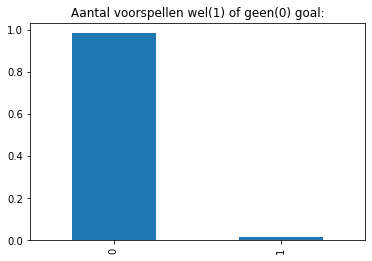

In [22]:
yvar['goal'].value_counts(normalize=True).plot(kind='bar')
plt.title('Aantal voorspellen wel(1) of geen(0) goal:')
plt.show()

In [23]:
yvar.head()

,uniekid,match_id,peil_minute,y_minute,goal
0,3788753796,3788753,45,46,1
1,3788765773,3788765,4,5,1
2,3788765773,3788765,24,25,1
3,3788765909,3788765,60,61,1
4,3788765773,3788765,66,67,1


#### xvar static opstellen

In [24]:
# static_data_matches = matches[['match_id', 'home_team', 'away_team', 'home_score','away_score', 'competition_stage']]
static_data_matches = matches[['match_id', 'competition_stage']]
static_data_matches.head()

,match_id,competition_stage
0,3788753,Group Stage
1,3788765,Group Stage
2,3795107,Quarter-finals
3,3795221,Semi-finals
4,3795506,Final


In [25]:
# create dummy-variables
dummie_categories = ['competition_stage']
df_dummies = pd.get_dummies(static_data_matches[dummie_categories])

#add dummy columns to dataset and drop old columns
static_data_matches_dummies = pd.concat([static_data_matches, df_dummies], axis=1)
static_data_matches_dummies = static_data_matches_dummies.drop(dummie_categories,axis = 1)
static_data_matches_dummies['match_id'] = static_data_matches_dummies['match_id'].astype(str)
static_data_matches_dummies.head(1)

,match_id,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3788753,0,1,0,0,0


In [26]:
# add static data to yvar

left_keys = ['match_id']
right_keys = ['match_id']
yvar_static_data = pd.merge(yvar, static_data_matches_dummies, left_on=left_keys, right_on=right_keys, how='left')

In [27]:
yvar_static_data.head(1)

,uniekid,match_id,peil_minute,y_minute,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3788753796,3788753,45,46,1,0,1,0,0,0


In [28]:
# yvar_static_data.loc[yvar_static_data['uniekid'] == 3788753796]

#### xvar dynamic opstellen

In [29]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,bad_behaviour_card,injury_stoppage_in_chain,pass_deflected,pass_inswinging,shot_one_on_one,block_deflection,block_save_block,foul_committed_penalty,foul_won_penalty,shot_deflected,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,player_off_permanent,shot_saved_off_target,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,dribble_no_touch,block_offensive,ball_recovery_offensive,shot_follows_dribble,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9427b18a-6b10-411f-90da-3d6240b80c71,1,NaN,NaN,3788753,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Finland,1835,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Finland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788754835


In [30]:
# position = name of the position the play was in in the moment of the play
# location = van links naar rechts, dus hoger is de aanval
# under_pressure = action was done under pressure
# player = player that does the event
# possession_team = team that has the possession

column_selection_events = ['uniekid', 'possession_team','player', 'minute','second', 'location', 'position', 'play_pattern', 'type','under_pressure']
events_for_all_matches = utils.get_events_per_id(events_all_matches,column_selection_events, uniek_id_list)

In [31]:
events_for_all_matches.head(1)

,uniekid,possession_team,player,minute,second,location,position,play_pattern,type,under_pressure
81,3788754835,Finland,Robin Lod,6,39,"[28.3, 61.4]",Right Center Midfield,Regular Play,Pass,True


In [32]:
print('Aantal uniekids die er zijn (2 per game): ', events_for_all_matches['uniekid'].nunique())

Aantal uniekids die er zijn (2 per game):  102


In [33]:
# feature engineering
events_all_matches_clean = utils.events_feature_engineering(events_for_all_matches)
events_all_matches_clean = events_all_matches_clean.set_index(['uniekid', 'minute', 'second'])

In [34]:
events_all_matches_clean.head(1)

,,,possession_team,player,position,play_pattern,type,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16
uniekid,minute,second,,,,,,,,,
3788754835,6,39,Finland,Robin Lod,Right Center Midfield,Regular Play,Pass,1,0.0,0.0,0


In [35]:
# create dummy-variables
dummie_categories = ['possession_team', 'player','position', 'play_pattern', 'type']
df_dummies = pd.get_dummies(events_all_matches_clean[dummie_categories])

#add dummy columns to dataset and drop old columns
events_all_matches_clean_dummies = pd.concat([events_all_matches_clean, df_dummies], axis=1)
events_all_matches_clean_dummies = events_all_matches_clean_dummies.drop(dummie_categories,axis = 1).reset_index()
events_all_matches_clean_dummies.drop('second', axis=1,inplace=True)
events_all_matches_clean_dummies.head(1)

,uniekid,minute,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum William McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher James Mepham,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,"player_Daniel O""Shaughnessy",player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Francesco Acerbi,player_Fredrik Jensen,player_Frenkie de Jong,player_Gaetano Castrovilli,player_Gareth Frank Bale,player_Georgi

In [36]:
events_all_matches_clean = events_all_matches_clean.reset_index()
print('Check of aantal rijen in de dummy-set gelijk is aan volgende df: ',
len(events_all_matches_clean.loc[
    (events_all_matches_clean['uniekid'] == 3788741909) &
    (events_all_matches_clean['minute'] == 1) ]))

Check of aantal rijen in de dummy-set gelijk is aan volgende df:  24


In [37]:
print('Check of aantal rijen in de dummy-set gelijk is aan vorige df: ',
len(events_all_matches_clean_dummies.loc[
    (events_all_matches_clean_dummies['uniekid'] == 3788741909) &
    (events_all_matches_clean_dummies['minute'] == 1) ]))

Check of aantal rijen in de dummy-set gelijk is aan vorige df:  24


In [38]:
# events_all_matches_clean_dummies.groupby(['uniekid','minute'])['under_pressure'].sum()

In [39]:
aggregated = utils.aggregate_events(events_all_matches_clean_dummies, ['uniekid','minute'], agg_type_max=True)

In [40]:
aggregated.head(1)

,uniekid,minute,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum William McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher James Mepham,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,"player_Daniel O""Shaughnessy",player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Francesco Acerbi,player_Fredrik Jensen,player_Frenkie de Jong,player_Gaetano Castrovilli,player_Gareth Frank Bale,player_Georgi

In [41]:
# samenvoegen van y en x variabelen
left_keys = ['uniekid', 'peil_minute']
right_keys = ['uniekid','minute']
total_df = pd.merge(yvar_static_data, aggregated, left_on=left_keys, right_on=right_keys, how='outer').sort_values(by='minute')

In [42]:
clean_total_df = total_df.drop(['match_id', 'peil_minute', 'y_minute', 'minute'], axis=1).sort_values(by='uniekid')

In [43]:
clean_total_df.head()

,uniekid,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum William McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher James Mepham,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,"player_Daniel O""Shaughnessy",player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian 

In [44]:
clean_total_df = clean_total_df.fillna(0)

In [45]:
clean_total_df['goal'].value_counts(normalize=True)

0.0    0.984658
1.0    0.015342
Name: goal, dtype: float64

In [46]:
clean_total_df.head()

,uniekid,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum William McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher James Mepham,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,"player_Daniel O""Shaughnessy",player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian 

#### test hypothesis per variable

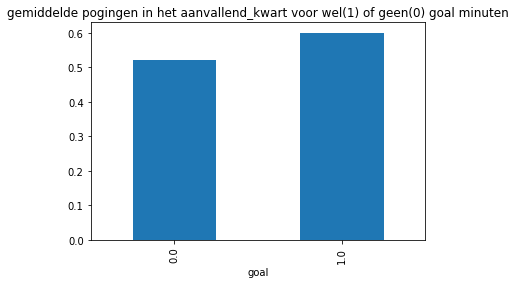

In [47]:
## more in aanvallend_kwart bij goals
clean_total_df.groupby('goal')['aanvallend_kwart'].mean().plot(kind='bar')
plt.title('gemiddelde pogingen in het aanvallend_kwart voor wel(1) of geen(0) goal minuten')
plt.show()

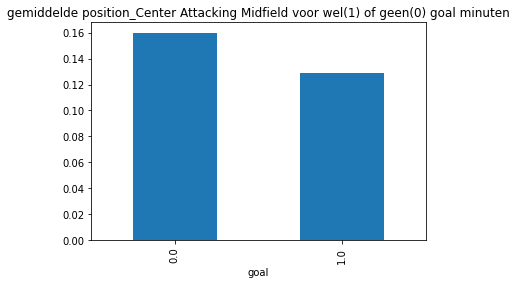

In [48]:
## more aanvallende positie bij goals?
clean_total_df.groupby('goal')['position_Center Attacking Midfield'].mean().plot(kind='bar')
plt.title('gemiddelde position_Center Attacking Midfield voor wel(1) of geen(0) goal minuten')
plt.show()

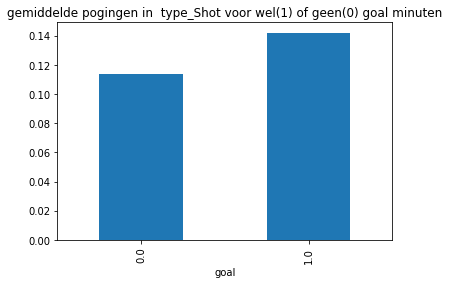

In [49]:
## more schoten bij goals ??
clean_total_df.groupby('goal')['type_Shot'].mean().plot(kind='bar')
plt.title('gemiddelde pogingen in  type_Shot voor wel(1) of geen(0) goal minuten')
plt.show()

In [50]:
clean_total_df.head(1)

,uniekid,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum William McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher James Mepham,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,"player_Daniel O""Shaughnessy",player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian 

In [51]:
# export dataset for training
clean_total_df.to_csv('./data/train_dataset.csv')